# DeepHit

In this notebook we show an example of how we can fit a [DeepHit](http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit) model.

If you are interested in **competing risks**, see [this notebook](https://github.com/havakv/pycox/blob/master/examples/deephit_competing_risks.ipynb) instead.

We will in the following: 
- use SUPPORT as an example dataset,
- use entity embeddings for categorical variables,
- use the [AdamWR optimizer](https://arxiv.org/pdf/1711.05101.pdf) with cyclical learning rates,
- use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from pycox import datasets
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
from torchtuples import optim
from torchtuples import callbacks as cb
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.preprocessing.label_transforms import LabTransDiscreteSurv
from torchtuples.practical import MixedInputMLP

`sklearn_pandas` can be installed with `! pip install sklearn-pandas`

In [2]:
np.random.seed(123456)
_ = torch.manual_seed(123456)

## Dataset

We load the SUPPORT data set and split in train, test and validation.

In [3]:
df_train = datasets.support.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,duration,event
0,82.709961,1.0,2.0,1.0,0.0,0.0,0.0,160.0,55.0,16.0,38.195309,142.0,19.000000,1.099854,30.0,1
1,79.660950,1.0,0.0,1.0,0.0,0.0,1.0,54.0,67.0,16.0,38.000000,142.0,10.000000,0.899902,1527.0,0
4,71.794983,0.0,1.0,1.0,0.0,0.0,0.0,65.0,135.0,40.0,38.593750,146.0,0.099991,0.399963,7.0,1
5,49.932980,0.0,1.0,1.0,0.0,0.0,0.0,70.0,105.0,33.0,38.195309,127.0,5.299805,1.199951,50.0,1
6,62.942989,0.0,5.0,2.0,1.0,0.0,1.0,116.0,130.0,35.0,38.195309,133.0,14.099609,0.799927,381.0,0


## Feature transforms
We have 14 covariates, in addition to the durations and event indicators.

We will standardize the 8 numerical covariates, and leave the 4 binary variables as is. 
The 3 categorical variables will be transformed to `int64` integers giving the category. The category 0 is reserved for `None` and very small categories that are set to `None`. 

In [5]:
cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
cols_leave = ['x1', 'x4', 'x5']
cols_categorical =  ['x2', 'x3', 'x6']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

In [6]:
x_fit_transform = lambda df: (x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: (x_mapper_float.transform(df), x_mapper_long.transform(df))

In [7]:
x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

## Label transforms

DeepHit is a discrete time method, so we need labels with index of the duration, and an event indicator.

SUPPORT is a continuous time data set, so we need to discretize it. We choose 25 equidistant time points between the min and max of the training durations.
This is handled by `LabTransDiscreteSurv`.

In [8]:
get_target = lambda df: (df['duration'].values, df['event'].values)
labtrans = LabTransDiscreteSurv(25)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = (x_val, y_val)

We can look at the discrete durations with the attribute `cuts`

In [9]:
labtrans.cuts

array([   0.      ,   84.541664,  169.08333 ,  253.625   ,  338.16666 ,
        422.70834 ,  507.25    ,  591.7917  ,  676.3333  ,  760.875   ,
        845.4167  ,  929.9583  , 1014.5     , 1099.0416  , 1183.5834  ,
       1268.125   , 1352.6666  , 1437.2084  , 1521.75    , 1606.2916  ,
       1690.8334  , 1775.375   , 1859.9166  , 1944.4584  , 2029.      ],
      dtype=float32)

## Neural net

We make a torch net. If this is new to you, we would recommend [the tutorials by PyTroch](https://pytorch.org/tutorials/).

For simplicity, we will just use the implementation of `torchtuples.practical.MixedInputMLP`.
By mixed input we refer to that we have both entity embeddings and regular numerical covariates.

We make embeddings half the size of the number of categories.

In [10]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

In [11]:
num_embeddings, embedding_dims

(array([8, 7, 4]), array([4, 3, 2]))

In [12]:
in_features = x_train[0].shape[1]
out_features = len(labtrans.cuts)
num_nodes = [32, 32, 32, 32]
batch_norm = True
dropout = 0.1
net = MixedInputMLP(in_features, num_embeddings, embedding_dims, num_nodes,
                    out_features, batch_norm, dropout)

In [13]:
net

MixedInputMLP(
  (embeddings): EntityEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(8, 4)
      (1): Embedding(7, 3)
      (2): Embedding(4, 2)
    )
  )
  (mlp): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=20, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1)
      )
      (2): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dro

## Fitting model

DeepHit has a loss that is a combination of a negative log-likelihood and a ranking loss. `alpha` is a parameter that controls the linear combination between the two, and `sigma` is a parameter used by the ranking loss. `alpha = 1` give a loss only containing the negative log-likelihood and `alpha = 0` give a pure ranking loss. Note that this is different than the original paper.

We make an AdamWR optimizer where we multiply the learning rate with 0.8 at the start of every cycle.

In [14]:
optimizer = optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8)
model = DeepHitSingle(net, optimizer, alpha=0.2, sigma=0.1)

We can use `lr_finder` to find a suitable initial learning rate. This method also sets the learning rate for the net.

0.02420128264794396

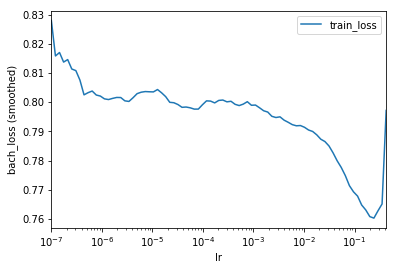

In [15]:
batch_size = 256
lrfind = model.lr_finder(x_train, y_train, batch_size, tolerance=1.5)
lrfind.plot()
lrfind.get_best_lr()

In [16]:
model.optimizer.param_groups[0]['lr']

0.02420128264794396

We have found that `get_best_lr` sometimes gives a little high learning rate, so  we instead set it to 0.01

In [17]:
model.optimizer.set_lr(0.01)
model.optimizer.param_groups[0]['lr']

0.01

As we have introduced shrinkage to the loss function, we also want to monitor the negative log-likelihood (nll) during training. We can add this to metrics.

For early stopping, we will use a callback that will stop at the end of the cycle if the current best model was not obtained in the current cycle.
We use the negative log-likelihood of the validation set for early stopping.

In [18]:
epochs = 512
callbacks = [cb.EarlyStoppingCycle()]
verbose = False # set to True if you want printout

In [19]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

CPU times: user 1min 31s, sys: 11.4 s, total: 1min 42s
Wall time: 38.6 s


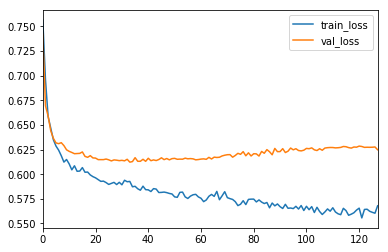

In [20]:
_ = log.plot()

In [21]:
surv = pd.DataFrame(model.predict_survival_function(x_test), index = labtrans.cuts)

In [22]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [23]:
ev.concordance_td()

0.622096677025229

In [24]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.integrated_brier_score(time_grid)

0.20528211277085848

In [25]:
ev.integrated_mbll(time_grid)

-0.6062462995442471